# Notes

* The effectiveness of model-based methods degrades fro systems with unstable process dynamics because of the inevitable modeling errors and instability issues arising out of unstable models.
* Complex process control applications cannot demand for supervised machine leraning approach as it is tedious and time consuming. The signal fed to the RL agent is usually the error between the set point and the current process variable. This is undesirable in case of unstable systems as it could lead to high prediction loss.
* Although DDPG has been proven to be the best choice for most of the continuous processes, upon thorough insights on the previously reported works, it is evident that DDPG is very sensitive o hyperparameter choices and this affects the generality of the algorithm.
* The proposed m-PPO uses a modified reward function, reduces the chances of damage to the system due to wildly changing behavior which can cause the system to exceed its usual operatingrange. In order to ensure system safety additionallly, early stopping criterion that explicitly penalizes the agent when the system's safe operating range is exceeded is also introduced.
* Contributions:
  1. To develop a model free data driven supervisory RL-PID controller for open loop stable as well as unstable processes. Data driven control approach independent of operator knowledge, process dynamics and tuning procedure is aimed via supervisory RL-PID controller.
  2. TO propose m-PPO algorithm with modified reward function, action repeat and early stoppng criterion to suit the dynamics of unstable processes to handle output multiplicities, hihg non linearity, parameter uncertainty and noise.
* Novelty:
  1. the controller tuning procedure is completely data driven approach
  2. no need to have comprehensive understanding of the unstable process
  3. no need to develop stable or unstable linear models
  4. no need for priori knowledge on the tuning procedures of thbe controller.
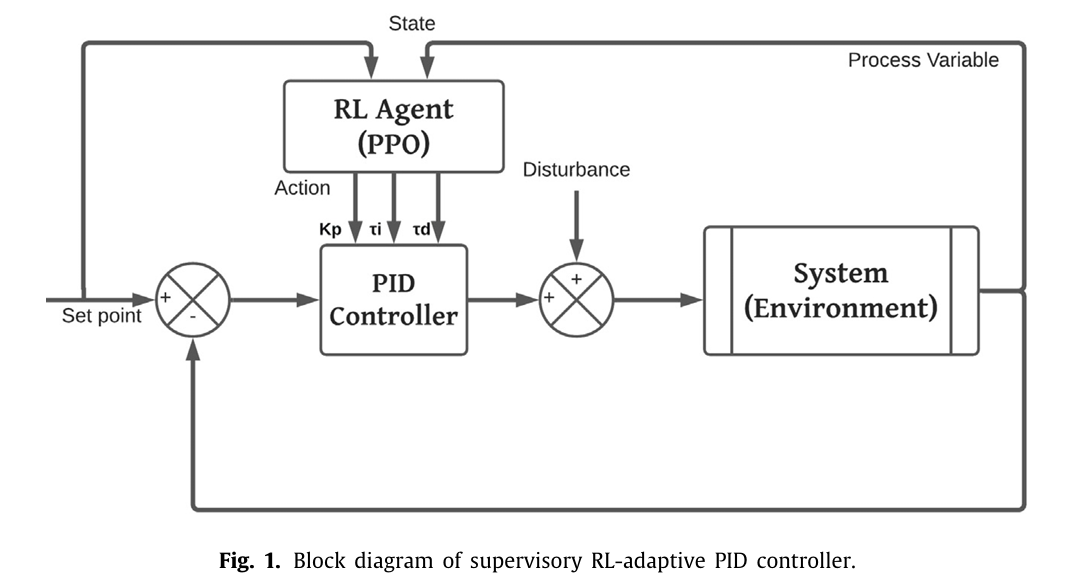
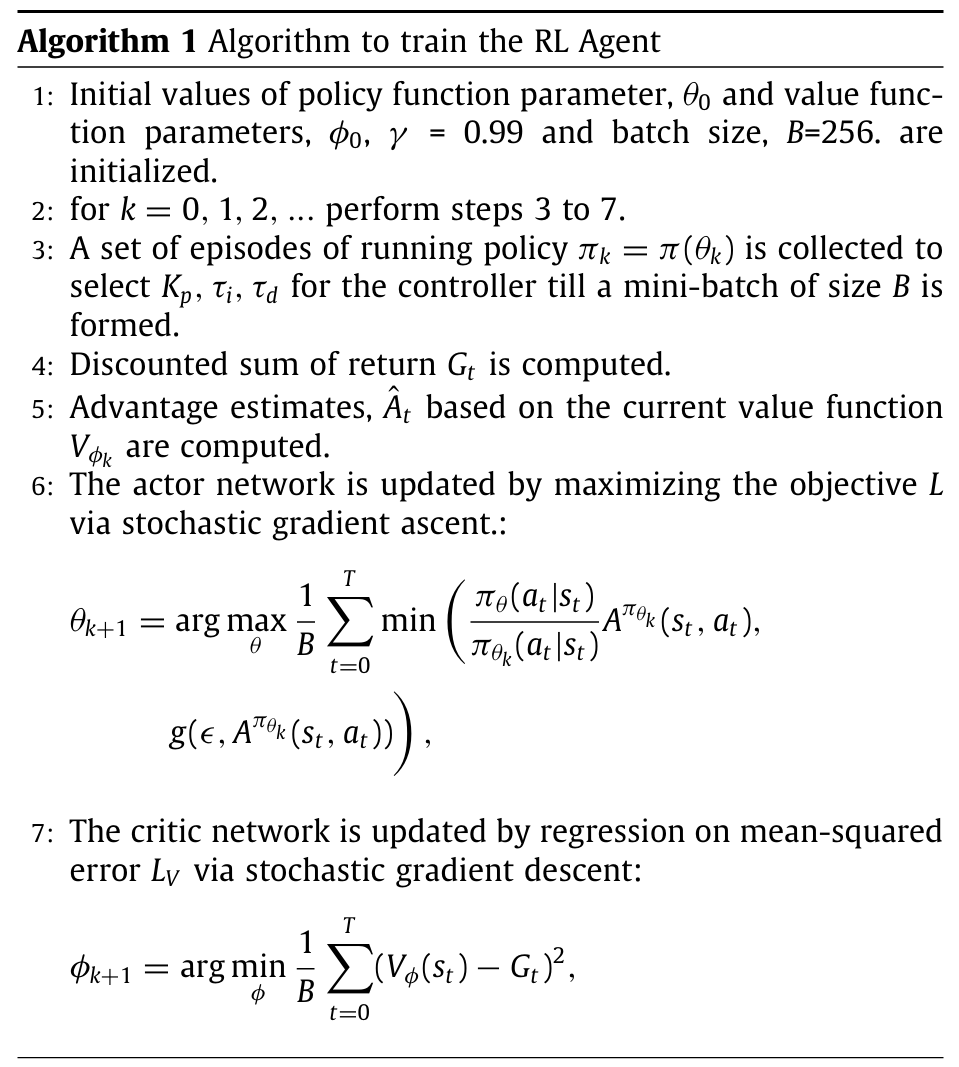

# code

In [ ]:
# part 1

class GymSystem(gym.Env):
    def __init__(
        self,
        uinit=uinit,
        yinit=yinit,
        num=num,
        dem=dem,
        system=SystemSimplePID,
        disturbance=disturbance,
        deterministic=deterministic,
        disturbance_value=disturbance_value,
    ):
        super().__init__()
        self.uinit=uinit
        self.yinit=yinit
        self.num=num
        self.dem=dem
        self.disturbance=disturbance
        self.deterministic=deterministic
        self.disturbance_value=disturbance_value
        self.system=system(
            uinit=self.uinit,
            yinit=self.yinit,
            num=self.num,
            dem=self.dem,
            disturbance=self.disturbance,
            deterministic=self.deterministic,
            disturbance_value=self.disturbance_value,
        )
        self.n_actions = self.system.n_actions
        self.action_space = spaces.Box(-1.0, 1.0, (self.n_actions,))
        self.n_states = self.system.n_states
        self.observation_space = spaces.Box(
            low=-100.0, high=100.0, shape=(self.n_states,), dtype=np.float32
        )

    def convert_stae(self):
        obs = self.system.get_state()
        obs = np.array(obs).astype(np.float32)
        return obs

    def convert_action(self, action):
        actions = (action + 1) * (
            self.system.input_high - self.system.input_low
        ) * 0.5 + self.system.input_low
        actions = np.clip(actions, self.system.input_low, self.system.input_high)
        return actions

    def unconvert_action(self, action):
        actions = (2.0 * action - (self.system.input_high + self.system.input_low)) / (self.system.input_high - self.system.input_low)
        actions = np.clip(actions, -1.0, 1.0)
        return actions

    def reset(self):
        _ = self.system.reset()
        obs = self.convert_state()
        return obs

    def get_reward(self, obs):
        # calculate error and reward
        e = obs[0] - obs[1]
        scale = 0.01
        e_squared = scale * np.abs(e) ** 2
        e_squared = np.minimum(e_squared, 5.0)
        tol = (5.0 - np.abs(e)) if np.abs(e) <= 0.01 else 0.0
        reward = -e_squared + tol
        return reward

    def step(self, action, debug=False):
        if debug:
            print("Original: ", action)
        action = self.convert_action(action)
        if debug:
            print("Converted: ", action)
        obs = self.system.step(*action)
        reward = self.get_reward(obs)
        done = bool(self.system.k == self.system.kfinal - 1)
        info = {}
        obs = self.convert_state()
        return obs, reward, done, info

    def render(self, mode="human"):
        if mode == "human":
            print("ISE: ", self.system.ise())
            self.system.plot()
        elif mode == "rgb_array":
            return self.system.plot(save=True)

    def close(self):
        pass
    
        
        
class ActionRepeat(gym.Wrapper):
    def __init__(self, env, amount=1):
        super().__init__(env)
        self.amount = amount

    def step(self, action):
        done = False
        total_reward = 0
        current_step = 0
        while current_step < self.amount and not done:
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            current_step += 1
        return obs, total_reward, done, info


class EarlyStopping(gym.Wrapper):
    def __init__(self, env, y_lim=[-50, 50], spk=5):
        super().__init__(env)
        self.y_lim = y_lim
        self.spk = spk
        self.sps = [
            i
            for i in range(len(self.env.system.r) - self.spk)
            if self.env.system.r[i][0] != self.env.system.r[i + self.spk][0]
            and i > self.env.system.ksp
        ]

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        if (
            self.env.system.y[self.env.system.k] > self.y_lim[1]
            or self.env.system.y[self.env.system.k] < self.y_lim[0]
        ):
            done = True
            reward += -20.0
        if self.env.system.k in self.sps:
            y = self.env.system.y[self.env.system.k][0]
            ysp = self.env.system.r[self.env.system.k][0]
            p_e = np.abs(y - ysp) / ysp
            if p_e < 0.1:
                p_rew = 5.0 * (1.0 - p_e)
                reward += p_rew
            if p_e > 0.1:
                p_rew = -1.0 * (1.0 + p_e)
                reward += p_rew
        return obs, reward, done, info